In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt 
import time
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

In [2]:
print('Loading data...')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

songs = pd.read_csv('songs.csv')

members = pd.read_csv('members.csv', parse_dates=['registration_init_time','expiration_date'])

train = train.merge(songs, on='song_id', how='left')

songs_extra = pd.read_csv('song_extra_info.csv')

test = test.merge(songs, on='song_id', how='left')

Loading data...


In [4]:
members['bd'][members['bd'] < 5] = 0

def Classify_Age(x):
    if(x == 0 or x == 105):
        return "0"
    if(x>= 13 and x<=22):
        return "13-22"
    if(x>=23 and x<=27):
        return "23-27"
    if(x>=28 and x<=34):
        return "28-34"
    if(x>=35):
        return "above 35"
    
members['AgeClass'] = members['bd'].apply(Classify_Age)
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

/Users/xiejingran/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how = 'left')

In [8]:
def ExtraCountry(s):
    return str(s)[0:2]

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra['country']=songs_extra['isrc'].apply(ExtraCountry)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

In [9]:

def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

def split_genre(x):
    l = x.split('|')
    return l[0]
train['genre_ids'].fillna('no_genre_id',inplace=True)
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre'] = train['genre_ids'].apply(split_genre)
test['genre'] = test['genre_ids'].apply(split_genre)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)
train = train.drop(['genre_ids'], axis=1)
test = test.drop(['genre_ids'], axis=1)

In [10]:
print ("Adding new features")

def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

Adding new features


In [11]:
def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].fillna('no_composer',inplace=True)
test['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

train['composer'] = train['composer'].str.split('|').str[0]
train['composer'] = train['composer'].str.split('/').str[0]
train['composer'] = train['composer'].str.split('\\').str[0]
train['composer'] = train['composer'].str.split(';').str[0]

test['composer'] = test['composer'].str.split('|').str[0]
test['composer'] = test['composer'].str.split('/').str[0]
test['composer'] = test['composer'].str.split('\\').str[0]
test['composer'] = test['composer'].str.split(';').str[0]

train['lyricist'] = train['lyricist'].str.split('|').str[0]
train['lyricist'] = train['lyricist'].str.split('/').str[0]
train['lyricist'] = train['lyricist'].str.split('\\').str[0]
train['lyricist'] = train['lyricist'].str.split(';').str[0]

test['lyricist'] = test['lyricist'].str.split('|').str[0]
test['lyricist'] = test['lyricist'].str.split('/').str[0]
test['lyricist'] = test['lyricist'].str.split('\\').str[0]
test['lyricist'] = test['lyricist'].str.split(';').str[0]
#print(train['composer'].categories)


In [12]:
#process artist count
def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')+x.count('|')+x.count("/")+x.count("\\")+1
train['artist_name'].fillna('no_artist',inplace=True)
test['artist_name'].fillna('no_artist',inplace=True)
train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

In [13]:
# extract out the main artist name
train['artist_name']=train['artist_name'].str.replace('.','')
train['artist_name']=train['artist_name'].str.replace(' ','')
test['artist_name']=test['artist_name'].str.replace('.','')
test['artist_name']=test['artist_name'].str.replace(' ','')
temp1=train['artist_name'].str.replace('[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+','-')
temp2=test['artist_name'].str.replace('[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+','-')
train['artist_name']=temp1.str.split('-',1).str[0]
test['artist_name']=temp2.str.split('-',1).str[0]

In [14]:
# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

In [15]:
# occurences of genre
_dict_count_genre_train = {k: v for k, v in train['genre'].value_counts().iteritems()}
_dict_count_genre_test = {k: v for k, v in test['genre'].value_counts().iteritems()}
def count_genre(x):
    try:
        return _dict_count_genre_train[x]
    except KeyError:
        try:
            return _dict_count_genre_test[x]
        except KeyError:
            return 0

train['count_genre'] = train['genre'].apply(count_genre).astype(np.int64)
test['count_genre'] = test['genre'].apply(count_genre).astype(np.int64)

In [16]:
# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)

In [17]:
# number of times the composer has been played
_dict_count_composer_played_train = {k: v for k, v in train['composer'].value_counts().iteritems()}
_dict_count_composer_played_test = {k: v for k, v in test['composer'].value_counts().iteritems()}
def count_composer_played(x):
    try:
        return _dict_count_composer_played_train[x]
    except KeyError:
        try:
            return _dict_count_composer_played_test[x]
        except KeyError:
            return 0

train['count_composer_played'] = train['composer'].apply(count_composer_played).astype(np.int64)
test['count_composer_played'] = test['composer'].apply(count_composer_played).astype(np.int64)

In [18]:
# number of times the lyricist has been played
_dict_count_lyricist_played_train = {k: v for k, v in train['lyricist'].value_counts().iteritems()}
_dict_count_lyricist_played_test = {k: v for k, v in test['lyricist'].value_counts().iteritems()}
def count_lyricist_played(x):
    try:
        return _dict_count_lyricist_played_train[x]
    except KeyError:
        try:
            return _dict_count_lyricist_played_test[x]
        except KeyError:
            return 0

train['count_lyricist_played'] = train['lyricist'].apply(count_lyricist_played).astype(np.int64)
test['count_lyricist_played'] = test['lyricist'].apply(count_lyricist_played).astype(np.int64)

In [19]:
train['gender'] = train['gender'].fillna('na')
train.fillna(0,inplace = True)
test.fillna(0,inplace = True)

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train1 = train

In [21]:
L = ['msno','gender','artist_name','country','AgeClass','genre','source_system_tab','source_screen_name','source_type','song_id','composer','lyricist']
for x in L:
    print(x)
    #temp = pd.concat([train[x],test[x]], ignore_index= 'true')
    le.fit(train1[x].tolist())
    temp1 = le.transform(train1[x].tolist())
    str = x+"_dum"
    train1[str] = temp1
    #test[str] = temp1[len(train[x]):len(temp1)]

msno
gender
artist_name
country
AgeClass
genre
source_system_tab
source_screen_name
source_type
song_id
composer
lyricist


In [24]:
train1 = train1.drop(L,axis=1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(train1.drop('target',axis=1), train1['target'], random_state= 0)

In [26]:
from sklearn.linear_model import LogisticRegression

start = time.time()
model = LogisticRegression(C=100).fit(X_train,Y_train)
print('time:',time.time() - start)
print('auc is ',model.score(X_test,Y_test))


time: 175.68177700042725
auc is  0.563759688346


[[664087 251763]
 [552819 375686]]


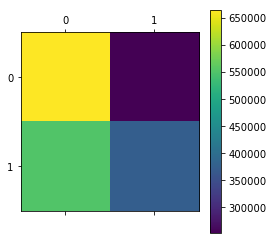

In [27]:
res = model.predict(X_test)
cm = confusion_matrix(Y_test.tolist(),res)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [28]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fprlr, tprlr, threshold = roc_curve(Y_test, preds)
roc_auclr = auc(fprlr, tprlr)

In [29]:
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier(max_depth=12).fit(X_train,Y_train)
print('time:',time.time() - start)
print('auc is ',model.score(X_test,Y_test))

time: 223.46975898742676
auc is  0.653213725123


[[546646 369204]
 [270393 658112]]


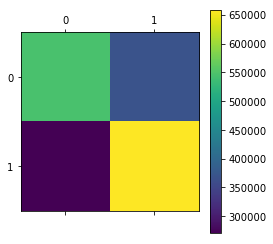

In [30]:
res = model.predict(X_test)
cm = confusion_matrix(Y_test.tolist(),res)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [31]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fprdt, tprdt, threshold = roc_curve(Y_test, preds)
roc_aucdt = auc(fprdt, tprdt)

In [32]:
train_set = lgb.Dataset(X_train,Y_train)
test_set = lgb.Dataset(X_test,Y_test)

In [33]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 150,
        'metric' : 'auc',
}

start = time.time()
model_f1 = lgb.train(params, train_set=train_set,  valid_sets=test_set, verbose_eval=5)
print(time.time() - start)

/Users/xiejingran/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's auc: 0.698057
[10]	valid_0's auc: 0.703802
[15]	valid_0's auc: 0.708828
[20]	valid_0's auc: 0.713548
[25]	valid_0's auc: 0.71714
[30]	valid_0's auc: 0.720888
[35]	valid_0's auc: 0.724051
[40]	valid_0's auc: 0.726897
[45]	valid_0's auc: 0.728848
[50]	valid_0's auc: 0.730639
[55]	valid_0's auc: 0.7319
[60]	valid_0's auc: 0.733024
[65]	valid_0's auc: 0.734883
[70]	valid_0's auc: 0.73673
[75]	valid_0's auc: 0.739505
[80]	valid_0's auc: 0.740922
[85]	valid_0's auc: 0.74194
[90]	valid_0's auc: 0.74315
[95]	valid_0's auc: 0.744715
[100]	valid_0's auc: 0.745308
[105]	valid_0's auc: 0.746235
[110]	valid_0's auc: 0.747274
[115]	valid_0's auc: 0.748325
[120]	valid_0's auc: 0.749666
[125]	valid_0's auc: 0.750725
[130]	valid_0's auc: 0.751991
[135]	valid_0's auc: 0.753085
[140]	valid_0's auc: 0.754492
[145]	valid_0's auc: 0.755603
[150]	valid_0's auc: 0.756182
134.2307231426239


[[603738 312112]
 [262795 665710]]


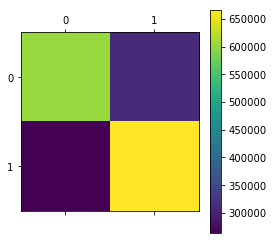

In [34]:
res1 = model_f1.predict(X_test)
res= []
for x in res1:
    if x >= 0.5:
        res.append(1)
    else:
        res.append(0)
cm = confusion_matrix(Y_test.tolist(),res)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [35]:
probs = model_f1.predict(X_test)
fprdum, tprdum, threshold = roc_curve(Y_test, probs)
roc_aucdum = auc(fprdum, tprdum)

In [47]:
L = ['msno','gender','artist_name','country','AgeClass','genre','source_system_tab','source_screen_name','source_type','song_id','composer','lyricist']
for x in L:
    str = x+"_dum"
    train = train.drop(str,axis=1)
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(train.drop('target',axis=1), train['target'], random_state= 0)
train_set = lgb.Dataset(X_train,Y_train)
test_set = lgb.Dataset(X_test,Y_test)

In [49]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 150,
        'metric' : 'auc',
}

start = time.time()
model_f1 = lgb.train(params, train_set=train_set,  valid_sets=test_set, verbose_eval=5)
print(time.time() - start)

/Users/xiejingran/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's auc: 0.728347
[10]	valid_0's auc: 0.740516
[15]	valid_0's auc: 0.74595
[20]	valid_0's auc: 0.750144
[25]	valid_0's auc: 0.753589
[30]	valid_0's auc: 0.756437
[35]	valid_0's auc: 0.759005
[40]	valid_0's auc: 0.761305
[45]	valid_0's auc: 0.763309
[50]	valid_0's auc: 0.764953
[55]	valid_0's auc: 0.766608
[60]	valid_0's auc: 0.768104
[65]	valid_0's auc: 0.769604
[70]	valid_0's auc: 0.770926
[75]	valid_0's auc: 0.772066
[80]	valid_0's auc: 0.773506
[85]	valid_0's auc: 0.774681
[90]	valid_0's auc: 0.775703
[95]	valid_0's auc: 0.776579
[100]	valid_0's auc: 0.777391
[105]	valid_0's auc: 0.778455
[110]	valid_0's auc: 0.779002
[115]	valid_0's auc: 0.779623
[120]	valid_0's auc: 0.780221
[125]	valid_0's auc: 0.780936
[130]	valid_0's auc: 0.781572
[135]	valid_0's auc: 0.78238
[140]	valid_0's auc: 0.782947
[145]	valid_0's auc: 0.783481
[150]	valid_0's auc: 0.784131
122.07114219665527


[[637682 278168]
 [256914 671591]]


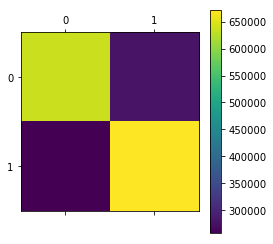

In [50]:
res1 = model_f1.predict(X_test)
#print(res1)
res= []
for x in res1:
    if x >= 0.5:
        res.append(1)
    else:
        res.append(0)
cm = confusion_matrix(Y_test.tolist(),res)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [52]:
probs = model_f1.predict(X_test)
fprnodum, tprnodum, threshold = roc_curve(Y_test, probs)
roc_aucnodum = auc(fprnodum, tprnodum)

In [51]:
gain = model_f1.feature_importance("gain")
ft = pd.DataFrame({'feature':model_f1.feature_name(), 'split':model_f1.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
ft

,feature,gain,split
0,msno,42.113757,1687
4,source_type,20.063301,491
29,count_song_played,9.760802,1447
6,artist_name,7.137370,2385
3,source_screen_name,5.203438,875
1,song_id,5.081320,382
2,source_system_tab,2.398393,121
31,count_artist_played,1.407043,1132
16,membership_days,1.236467,756
7,composer,0.999871,436


In [54]:

L=['gender','smaller_song','artist_composer_lyricist','artist_composer','artist_count','genre_ids_count','lyricists_count','composer_count']
train2 = train.drop(L,axis = 1)
for col in train2.columns:
    if train2[col].dtype == object:
        train2[col] = train2[col].astype('category')
X_train, X_test, Y_train, Y_test= train_test_split(train2.drop('target',axis=1), train2['target'], random_state= 0)
train_set = lgb.Dataset(X_train,Y_train)
test_set = lgb.Dataset(X_test,Y_test)

In [55]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 150,
        'metric' : 'auc',
}
    
start = time.time()
model_f1 = lgb.train(params, train_set=train_set,  valid_sets=test_set, verbose_eval=5)
print(time.time() - start)

/Users/xiejingran/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's auc: 0.730502
[10]	valid_0's auc: 0.742787
[15]	valid_0's auc: 0.749361
[20]	valid_0's auc: 0.752914
[25]	valid_0's auc: 0.756203
[30]	valid_0's auc: 0.758601
[35]	valid_0's auc: 0.761154
[40]	valid_0's auc: 0.763452
[45]	valid_0's auc: 0.765409
[50]	valid_0's auc: 0.767117
[55]	valid_0's auc: 0.76862
[60]	valid_0's auc: 0.769736
[65]	valid_0's auc: 0.771126
[70]	valid_0's auc: 0.772285
[75]	valid_0's auc: 0.773341
[80]	valid_0's auc: 0.774097
[85]	valid_0's auc: 0.77518
[90]	valid_0's auc: 0.776169
[95]	valid_0's auc: 0.777164
[100]	valid_0's auc: 0.778496
[105]	valid_0's auc: 0.779527
[110]	valid_0's auc: 0.78057
[115]	valid_0's auc: 0.78126
[120]	valid_0's auc: 0.781909
[125]	valid_0's auc: 0.782555
[130]	valid_0's auc: 0.783361
[135]	valid_0's auc: 0.78412
[140]	valid_0's auc: 0.784788
[145]	valid_0's auc: 0.785295
[150]	valid_0's auc: 0.785658
123.36552214622498


[[638696 277154]
 [255310 673195]]


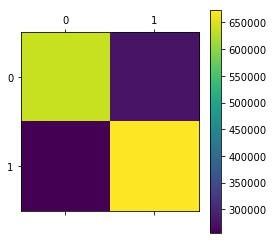

In [56]:
res1 = model_f1.predict(X_test)
#print(res1)
res= []
for x in res1:
    if x >= 0.5:
        res.append(1)
    else:
        res.append(0)
cm = confusion_matrix(Y_test.tolist(),res)
print(cm)
plt.matshow(cm)
plt.colorbar()
plt.show()

In [57]:
probs = model_f1.predict(X_test)
fprb, tprb, threshold = roc_curve(Y_test, probs)
roc_aucb = auc(fprb, tprb)

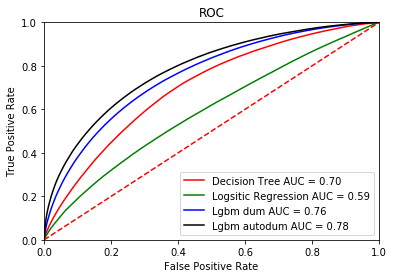

In [58]:
import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fprdt, tprdt, 'b', color = 'red' , label = 'Decision Tree AUC = %0.2f' % roc_aucdt)
plt.plot(fprlr, tprlr, 'b', color = 'green', label = 'Logsitic Regression AUC = %0.2f' % roc_auclr)
plt.plot(fprdum, tprdum , 'b', color = 'blue', label = 'Lgbm dum AUC = %0.2f' % roc_aucdum)
plt.plot(fprnodum, tprnodum , 'b', color = 'black', label = 'Lgbm autodum AUC = %0.2f' % roc_aucnodum)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()